##  COMP24112 Lab 2: News Article Classification by k-NN

## 1. Task description

You will work on a news article classification task.
The provided dataset includes a total of 800 articles taken from Reuters newswire.
They belong to 4 classes: "earn" (0), "crude" (1), "trade" (2) and "interest" (3).
There are 200 articles per class.
Each article is characterised by word occurrences.
The list of used words is called a vocabulary.
In our dataset, the vocabulary includes a total of 6428 words. 

## 2. Preparation

First we need to import the data.
Run the below cell to load the data using NumPy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

data, labels, class_names, vocabulary = np.load("ReutersNews_4Classes_sparse.npy", allow_pickle=True)

### A Note on Sparsity

Most documents only contain a small subset of the vocabulary, resulting in a very sparse data matrix.
To handle the sparsity, in this exercise `data` is represented as a `scipy.sparse.csr_matrix`, which can store sparse matrices efficiently while still allowing efficient row-based indexing.
You can learn more about `csr_matrix` and other ways of dealing with sparse matrices at https://docs.scipy.org/doc/scipy/reference/sparse.html.

Note, however, that `data` is **not** a normal NumPy array.
While most operations will be the same as with a normal dense array, **you cannot use a sparse matrix to index another matrix**.
If you need to do this, either first convert the matrix to a NumPy array with the `toarray()` method, or use methods specifically designed to work with sparse matrices.

In [2]:
print(data[41,:]) # A sparse row vector; the output will be the non-zero indices and their values.
print(data[41,:].toarray()) # Convert back to a NumPy array. Note that the result is a (1, 6428) matrix, not a vector.
# print(vocabulary[data[41,:] > 0]) # Can't index vocabulary with a sparse matrix.
rows, columns, values = scipy.sparse.find(data[41,:]) # Find the non-zero entries in the 42nd document.
print(vocabulary[columns]) # Prints the words present in the 42nd document.

  (0, 2)	1
  (0, 3)	3
  (0, 5)	1
  (0, 8)	1
  (0, 10)	1
  (0, 11)	1
  (0, 12)	1
  (0, 13)	1
  (0, 21)	2
  (0, 24)	1
  (0, 105)	1
  (0, 127)	1
  (0, 227)	1
  (0, 275)	1
  (0, 334)	2
  (0, 341)	1
  (0, 348)	1
  (0, 359)	1
  (0, 411)	1
  (0, 426)	1
  (0, 1428)	1
  (0, 2058)	1
  (0, 5555)	1
[[0 0 1 ... 0 0 0]]
['share' 'split' 'say' 'two-for-one' 'shareholder' 'annual' 'meeting'
 'reuter' 'ct' 'note' 'company' 'pay' 'subject' 'increase' 'stock'
 'dividend' 'april' 'northern' 'declare' 'approval' 'telecom' 'post-split'
 'nt']


To see the full vocabulary, you can run

In [3]:
print(", ".join(vocabulary))

island, telephone, share, split, approve, say, previously, announce, two-for-one, common, shareholder, annual, meeting, reuter, year, net, shr, loss, nil, vs, profit, ct, rev, mln, note, current, include, charge, discontinue, operation, dlr, ec, state, tax, majority, european, community, member, strong, reservation, import, domestically-produced, oil, fat, propose, commission, senior, diplomat, special, committee, agricultural, expert, voice, objection, measure, prepare, ground, farm, begin, monday, add, france, italy, indicate, support, proposal, lead, initially, tonne, 1987/88, price, round, complete, sale, french, unit, business, compagnie, francaise, group, investor, employee, minnesota, disclose, term, deal, plan, asset, electronic, shoe, town, end, jan, respectively, december, wisconsin, fwb, buy, bank, corp, acquire, bancshare, cash, acquisition, hold, company, total, billion, purchase, time, earning, office, paul, area, american, product, 3rd, qtr, period, feb, mth, avg, 4th, s

You can see how many times article $i$ contains word $j$ using

In [4]:
i, j = 40, 2
print(data[i,j])

4


You can see which class the $i$th article belongs to using

In [5]:
print(labels[i])

0


For instance, by running

In [6]:
print("Occurrences:", data[0,10])
print("Class:", class_names[labels[0]])
print("Word:", vocabulary[10])

Occurrences: 2
Class: earn
Word: shareholder


you can see that the 11th word appears twice in the first document, the first document belongs to the class "earn", and the 11th word is "shareholder".

The following function randomly selects a subset of the data.

In [7]:
def sample_indices(labels, *num_per_class):
    """
    Returns randomly selected indices. It will return the specified number of indices for each class.
    """
    indices = []
    for cls, num in enumerate(num_per_class):
        cls_indices = np.where(labels == cls)[0]
        indices.extend(np.random.choice(cls_indices, size=num, replace=False))
    return np.array(indices)

For instance, to get one sample from the first class, two from the second, three from the third, and four from the fourth, you can run:

In [8]:
indices = sample_indices(labels, 1, 2, 3, 4)
print("Returned indices:", indices)
print("Samples:", data[indices])
print("Corresponding classes:", labels[indices])

Returned indices: [ 83 261 329 413 590 409 726 730 799 620]
Samples:   (0, 13)	1
  (0, 15)	1
  (0, 19)	3
  (0, 20)	1
  (0, 24)	1
  (0, 73)	2
  (0, 105)	1
  (0, 107)	5
  (0, 157)	1
  (0, 331)	1
  (0, 458)	4
  (0, 467)	1
  (0, 1514)	1
  (0, 6052)	1
  (1, 5)	7
  (1, 13)	2
  (1, 14)	1
  (1, 15)	1
  (1, 17)	1
  (1, 23)	4
  (1, 26)	1
  (1, 30)	5
  (1, 32)	1
  (1, 37)	1
  (1, 40)	2
  :	:
  (9, 332)	1
  (9, 391)	1
  (9, 434)	1
  (9, 435)	1
  (9, 441)	1
  (9, 442)	1
  (9, 443)	2
  (9, 485)	2
  (9, 682)	1
  (9, 703)	2
  (9, 754)	3
  (9, 822)	3
  (9, 934)	1
  (9, 984)	4
  (9, 1122)	1
  (9, 1502)	1
  (9, 1588)	1
  (9, 1696)	1
  (9, 1848)	1
  (9, 2164)	1
  (9, 2302)	1
  (9, 2552)	1
  (9, 3013)	1
  (9, 3646)	3
  (9, 4646)	1
Corresponding classes: [0 1 1 2 2 2 3 3 3 3]


## 3. k-NN Implementation (4 Marks, Normal)

Now, you will need to implement a k-NN classifier by filling the code below.
This function should support two types of distance measures: Euclidean distance and cosine distance (defined as 1 - cosine similarity). It should take a set of training samples, a user-specified neighbour number, a distance option, and features of a set of testing samples as the input.
It should return the predicted classes for the input set of testing samples.

In order to get 4 marks, you are asked to implement the k-NN classifier from scrach without relying on any machine learning library, particularly the distance calculation. But you are allowed to research NumPy functions relating to sorting. If you decide to use existing distance implementation from libraries, e.g., `sklearn.metrics.pairwise_distances` imported as `cdist`, you can get at most 3 marks.

**Your implementation must NOT make use of Python loops over individual samples or features**.
You should use functions that operate on whole matrices, as this will be much faster than looping in Python.
Each experiment below is expected to take no more than 2 minutes to run.

In [9]:
import scipy.stats
from scipy.sparse import csr_matrix

def knn_classify(test_samples, training_data, training_labels, metric="euclidean", k=1):
    """
    Performs k-nearest neighbour classification on the provided samples,
    given training data and the corresponding labels.
    
    test_samples: An m x d matrix of m samples to classify, each with d features.
    training_data: An n x d matrix consisting of n training samples, each with d features.
    training_labels: A vector of size n, where training_labels[i] is the label of training_data[i].
    metric: The metric to use for calculating distances between samples.
    k: The number of nearest neighbours to use for classification.
    
    Returns: A vector of size m, where out[i] is the predicted class of test_samples[i].
    """
    if(metric == "euclidean"):
        m = test_samples.shape[0]
        n = training_data.shape[0]
        
        # Calculate an m x n distance matrix.
        #first equals to X*X.T
        first =(test_samples @ test_samples.T).diagonal()
        first = np.array([first])
        first = first.T
        first = (np.tile(first,(1,n)))
        first = csr_matrix(first)
        
        #second equals to 2*X*Y.T
        second = (test_samples@training_data.T) 
        second = 2* second
        
        #third equals to y*y.T
        third = (training_data @ training_data.T).diagonal()
        third = np.array([third])
        third = np.tile(third,(m,1))
        third = csr_matrix(third)
        
        #distance gives the euclidean distance
        pairwise_distance = first-second+third
        distance= np.sqrt(pairwise_distance.todense())  
#         print(pairwise_distance)

        # Find the k nearest neighbours of each samples as an m x k matrix of indices.
        nearest_neighbours = np.argsort(distance,axis =1)[:,:k]
#         print(nearest_neighbours)
        
        # Look up the classes corresponding to each index.
        nearest_labels = training_labels[nearest_neighbours]
#         print(nearest_labels)

        # Return the most frequent class on each row.
        # Note: Ensure that the returned vector does not contain any empty dimensions.
        # You may find the squeeze method useful here.
        mode,count = scipy.stats.mode(nearest_labels,axis =1)
        frequent = np.squeeze(mode)
        
        return frequent
    else:
        m = test_samples.shape[0]
        n = training_data.shape[0]
        #calculate absolute value of x
        first =(test_samples @ test_samples.T).diagonal()
        first = np.array([first])
        first = first.T
        first = np.sqrt(first)
        
        #calculate absolute value of y
        second = (training_data @ training_data.T).diagonal()
        second = np.array([second])
        second = np.sqrt(second)
        
        #calculate consine similarity
        upper = test_samples@training_data.T
        bottom = first @ second
        final = (upper.todense())/bottom
        one = np.array([1])
        one = np.tile(one,(m,1))
        one = np.tile(one,(1,n))
        final = one-final
        final = csr_matrix(final)
        
        nearest_neighbours = np.argsort(final.todense(),axis =1)[:,:k]
#         print(nearest_neighbours)
        
        # Look up the classes corresponding to each index.
        nearest_labels = training_labels[nearest_neighbours]
#         print(nearest_labels)

        # Return the most frequent class on each row.
        # Note: Ensure that the returned vector does not contain any empty dimensions.
        # You may find the squeeze method useful here.
        mode,count = scipy.stats.mode(nearest_labels,axis =1)
        frequent = np.squeeze(mode)
        
        return frequent

## 4. Experiments (12 Marks in Total)

Use your k-NN function to perform the following experiments.

### Experiment 1 (4 Marks, Easy)

Randomly select 80 articles per class for training, and use the remaining articles for testing.
Fix a neighbour number setting as you see fit. Perform k-NN classification using the Euclidean distance and test it.

Repeat this process 20 times (trials).
Calculate the mean and standard deviation of the testing accuracies. Print out the mean and standard deviation.

In [74]:
# Your code goes here
correct = []
wrong = []
accuricies = []

#Run 20 trials
for i in range(20):
    #selecting 80 atricles per class
    indices = sample_indices(labels, 80, 80, 80, 80)
    #remaining articles for training
    remain = list(set(range(800))-set(indices))
    
    #run K-NN with fixed k =1(euclidean)
    predicted = knn_classify(data[indices],data[remain],labels[remain],metric="euclidean",k=1)
    i=0
    correct_predict = 0
    wrong_predict = 0
    #checking label with predicted 
    for label in labels[indices]:
        if(label == predicted[i]):
            correct_predict += 1
        else:
            wrong_predict += 1
        i+=1
    correct.append(correct_predict)
    wrong.append(wrong_predict)
    accuricies.append(correct_predict/800)
print(correct)
print(wrong)
print(accuricies)

#printing mean and standard deviation
mean =0
standard_deviation = 0
for i in accuricies:
    mean +=i
mean = mean/20
print("mean :", mean)
for i in range(20):
    standard_deviation += np.power((accuricies[i]-mean),2)
standard_deviation = np.sqrt(standard_deviation/20)
print("standard deviation for euclidean:",standard_deviation)


[297, 284, 304, 293, 288, 300, 303, 298, 288, 295, 294, 299, 284, 292, 308, 290, 297, 298, 286, 301]
[23, 36, 16, 27, 32, 20, 17, 22, 32, 25, 26, 21, 36, 28, 12, 30, 23, 22, 34, 19]
[0.37125, 0.355, 0.38, 0.36625, 0.36, 0.375, 0.37875, 0.3725, 0.36, 0.36875, 0.3675, 0.37375, 0.355, 0.365, 0.385, 0.3625, 0.37125, 0.3725, 0.3575, 0.37625]
mean : 0.36868749999999995
standard deviation for euclidean: 0.008277180603925474


Use the same neighbour number, but use the cosine distance instead of the Euclidean distance.
Repeat the same experiment.

Print out the mean and standard deviation.

In [75]:
# Your code goes here
correct = []
wrong = []
accuricies = []
for i in range(20):
    indices = sample_indices(labels, 80, 80, 80, 80)
    remain = list(set(range(800))-set(indices))
    
    #changing euclidean to cosine
    predicted = knn_classify(data[indices],data[remain],labels[remain],metric="cosine",k=1)
    i=0
    correct_predict = 0
    wrong_predict = 0
    for label in labels[indices]:
        if(label == predicted[i]):
            correct_predict += 1
        else:
            wrong_predict += 1
        i+=1
    correct.append(correct_predict)
    wrong.append(wrong_predict)
    accuricies.append(correct_predict/800)
print(correct)
print(wrong)
print(accuricies)
for i in accuricies:
    mean +=i
mean = mean/20
print("mean: ", mean)
for i in range(20):
    standard_deviation += np.power((accuricies[i]-mean),2)
standard_deviation = np.sqrt(standard_deviation/20)
print("standard deviation for cosine :",standard_deviation)


[309, 308, 306, 312, 310, 314, 309, 308, 314, 311, 311, 304, 310, 311, 314, 314, 313, 313, 314, 309]
[11, 12, 14, 8, 10, 6, 11, 12, 6, 9, 9, 16, 10, 9, 6, 6, 7, 7, 6, 11]
[0.38625, 0.385, 0.3825, 0.39, 0.3875, 0.3925, 0.38625, 0.385, 0.3925, 0.38875, 0.38875, 0.38, 0.3875, 0.38875, 0.3925, 0.3925, 0.39125, 0.39125, 0.3925, 0.38625]
mean:  0.40680937500000003
standard deviation for cosine : 0.027677510488425427


Explain in your report which distance measure gives better performance and analyse the reason. 

### Experiment 2 (4 Marks, Easy)

Using the distance measure that you found performs better in Experiment 1.

Randomly select 80 articles per class for training, and use the remaining articles for testing. Perform k-NN classification with the neighbour number $k$ varying from 1 to 50.

For each values of $k$, repeat the training process by 20 trials and record the average training error rates and standard deviation.

Do the same for testing errors.

In [111]:
# Your code goes here
# Your code goes here
averages = []
sds = []
avg0 = []
sds0 = []
#changing the value of k
for j in range(50):
    correct = []
    wrong = []
    training_error = []
    accuricies = []
    #repeating 20 trials
    for index in range(20):
        i=0
        training = sample_indices(labels, 80, 80, 80, 80)
        testing = list(set(range(800))-set(training))
        
        # keep same as training set and test set
        predicted = knn_classify(data[training],data[training],labels[training],metric="cosine",k = j+1)
        correct_predict = 0
        wrong_predict = 0
        for label in labels[training]:
            if(label == predicted[i]):
                correct_predict += 1
            else:
                wrong_predict += 1
            i+=1
            correct.append(correct_predict)
            wrong.append(wrong_predict)
            training_error.append(wrong_predict/800)
            accuricies.append(correct_predict/800)
    #getting averages and standard deviation
    avg0.append(np.average(accuricies))
    sds0.append(scipy.stats.tstd(accuricies))
    averages.append(np.average(training_error))
    sds.append(scipy.stats.tstd(training_error))
print("averages:",averages)
print("standard deviations:",sds)

averages: [0.0, 0.0017630859375000001, 0.0031376953125, 0.0038818359375, 0.004434765625, 0.005554492187500001, 0.005259375, 0.006568359375, 0.00573359375, 0.0061662109375, 0.006314453124999999, 0.007562109375, 0.007086718749999999, 0.006973242187499999, 0.006123046875, 0.0077066406249999995, 0.006234960937499999, 0.0076654296875, 0.0079310546875, 0.007102734374999999, 0.007544921874999999, 0.007636328125, 0.00851953125, 0.0074074218749999995, 0.008078125, 0.0084142578125, 0.0089091796875, 0.008117968750000001, 0.009758203125, 0.0077654296875, 0.0087119140625, 0.0094837890625, 0.009150390625, 0.0092138671875, 0.009398242187500001, 0.010714453125, 0.010291015625, 0.00984609375, 0.010303515624999999, 0.010470898437499997, 0.009372265625, 0.0100205078125, 0.009183984374999999, 0.010292187500000001, 0.0087107421875, 0.0101501953125, 0.010021484374999999, 0.010055273437499998, 0.010275976562500002, 0.0104123046875]
standard deviations: [0.0, 0.0021725897816277646, 0.0031096312912623526, 0.00

Produce an error bar plot showing the training error rate for each $k$ here:

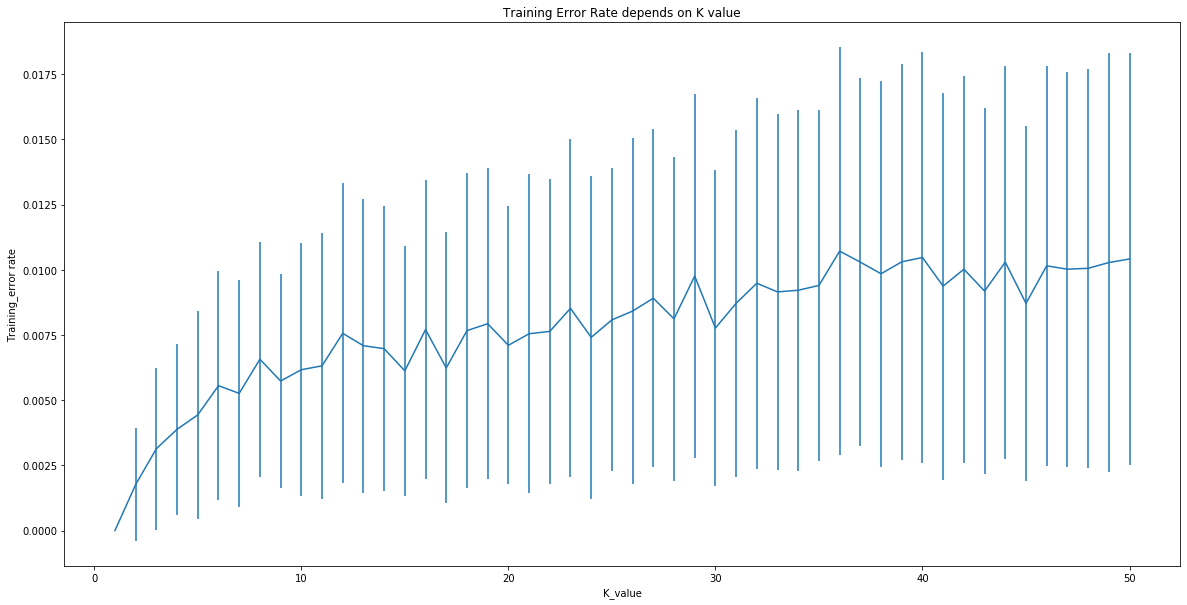

In [112]:
# Your code goes here
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
x = np.arange(1,51,1)
# print(x)
y = averages
# print(y)
plt.errorbar(x, y,yerr =sds)
plt.xlabel('K_value')
plt.ylabel('Training_error rate')
plt.title('Training Error Rate depends on K value')
plt.show()

Produce your testing error bar plot here:

In [113]:
# Your code goes here
# Your code goes here
averages = []
sds = []
avg1 = []
sds1 =[]
for j in range(50):
    correct = []
    wrong = []
    training_error = []
    accuricies = []
    for index in range(20):
        i=0
        training = sample_indices(labels, 80, 80, 80, 80)
        testing = list(set(range(800))-set(training))
        #changing the testing set which is different with training set
        predicted = knn_classify(data[testing],data[training],labels[training],metric="cosine",k = j+1)
        correct_predict = 0
        wrong_predict = 0
        for label in labels[testing]:
            if(label == predicted[i]):
                correct_predict += 1
            else:
                wrong_predict += 1
            i+=1
            correct.append(correct_predict)
            wrong.append(wrong_predict)
            training_error.append(wrong_predict/800)
            accuricies.append(correct_predict/800)
    avg1.append(np.average(accuricies))
    sds1.append(scipy.stats.tstd(accuricies))
    averages.append(np.average(training_error))
    sds.append(scipy.stats.tstd(training_error))
print("averages:",averages)
print("standard deviation:",sds)

averages: [0.010655078125, 0.009166276041666666, 0.012349609374999999, 0.011730729166666667, 0.012129557291666667, 0.010498437499999999, 0.010679947916666667, 0.011759895833333332, 0.011915755208333332, 0.010843489583333333, 0.011804557291666667, 0.012080468749999998, 0.012036197916666668, 0.011622265625, 0.012081901041666666, 0.012397526041666667, 0.011610416666666665, 0.012012239583333332, 0.012363541666666667, 0.013177213541666667, 0.012777864583333333, 0.012507161458333332, 0.012922265625, 0.012419791666666666, 0.012554296874999999, 0.013854036458333333, 0.013560546874999998, 0.013169531249999998, 0.013510286458333335, 0.014383984375, 0.013788411458333334, 0.014213151041666665, 0.014235026041666666, 0.014070572916666664, 0.014190364583333332, 0.014977473958333333, 0.014887890624999999, 0.01543515625, 0.016199739583333334, 0.016313541666666667, 0.015390885416666666, 0.015676432291666664, 0.014791666666666667, 0.015865104166666668, 0.016588671875, 0.015623307291666666, 0.016191796874

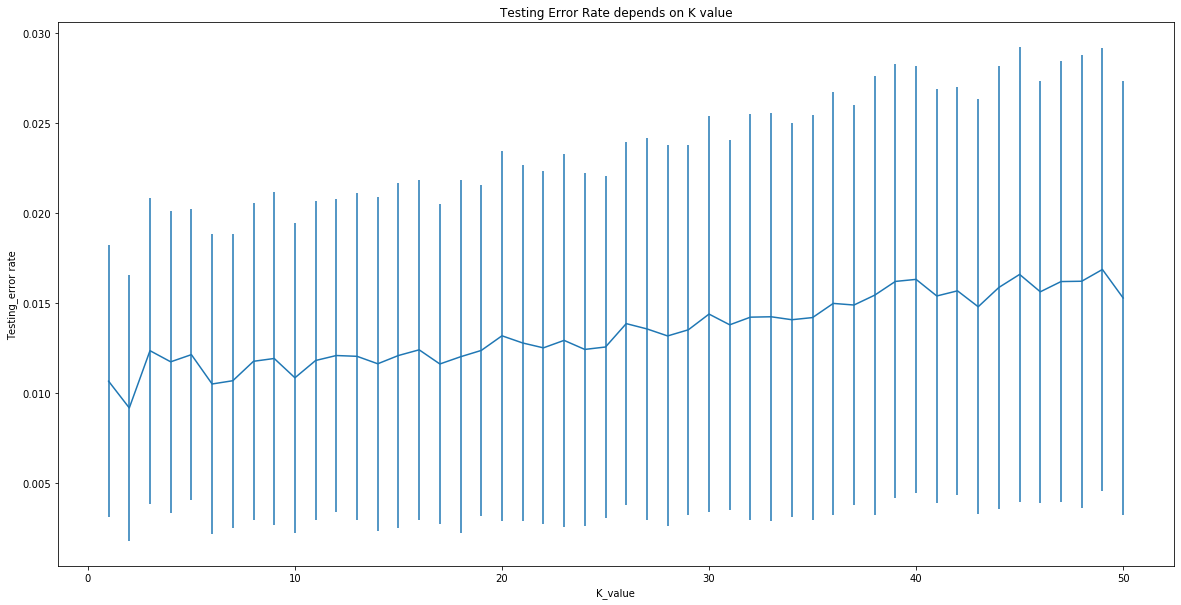

In [114]:
plt.figure(figsize=(20,10))
x = np.arange(1,51,1)
# print(x)
y = averages
# print(y)
plt.errorbar(x, y,yerr =sds)
plt.xlabel('K_value')
plt.ylabel('Testing_error rate')
plt.title('Testing Error Rate depends on K value')
plt.show()

**Remember that all graphs should have axis labels and a title.**

Discuss in your report the difference between the training and testing accuracies and its indication. Analyse in your report the effect of $k$ based on this experiment. 

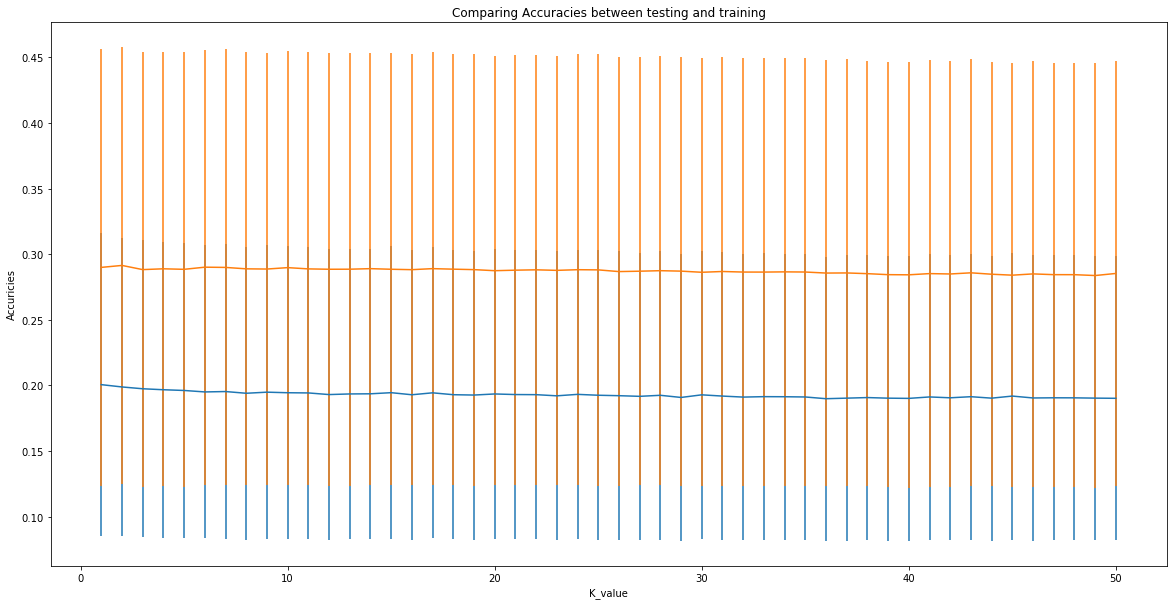

In [121]:
plt.figure(figsize=(20,10))
x = np.arange(1,51,1)
# print(x)
y0 = avg0
y1 = avg1
plt.errorbar(x, y0,yerr =sds0)
plt.errorbar(x,y1, yerr =sds1)
plt.xlabel('K_value')
plt.ylabel('Accuricies')
plt.title('Comparing Accuracies between testing and training')
plt.show()

### Experiment 3 (4 Marks, Normal)

Compare three 5-NN classifiers using cosine distance. In order to get 4 marks, you should implement the confusion matrix calculation from scrach yourself. If you decide to use existing implementation for confusion matrix calculation, you can get at most 3 marks.

First, randomly select 100 articles per class and keep these as your testing samples. Set all the remaining articles as the training set.

In [126]:
# Your code goes here
testing = sample_indices(labels, 100, 100, 100, 100)
training = list(set(range(800))-set(testing))

Then do the following:

(1) Train the first classifier using the traning set.
Compute the confusion matrix for the 4 classes using the testing samples.

Print out the numbers of the training and testing samples belonging to each class, the $2\times 2$ confusion matrix for each of the 4 classes, and the overall accuracy of the classifier.

In [127]:
# Your code goes here
print("testing label class 0 : 100 ,class 1: 100 ,class 2: 100, class 3: 100" )
print("training label class 0 : 100 ,class 1: 100 ,class 2: 100, class 3: 100" )
confusion_matrix_0 =[[0,0],[0,0]]
confusion_matrix_1 =[[0,0],[0,0]]
confusion_matrix_2 =[[0,0],[0,0]]
confusion_matrix_3 =[[0,0],[0,0]]
predicted = knn_classify(data[testing],data[training],labels,metric="euclidean",k =5)
# print(predicted)
i=0
correct = 0
#checking all the posibilities
for label in labels[testing]:
        if(label == predicted[i]):
            correct +=1
            # it correct add to true positive other wise True negative
            if(label == 0):
                confusion_matrix_0[0][0] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[1][1] +=1
            elif(label == 1):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[0][0] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[1][1] +=1
            elif(label == 2):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[0][0] +=1
                confusion_matrix_3[1][1] +=1
            elif(label == 3):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[0][0] +=1
        else:
            if(label == 0):
                if(predicted[i] ==1):
                    #predicted:False positive,label:False negative otherwise True negative
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 2):
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3):  
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 1):
                if(predicted[i] ==0):
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 2):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3):  
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 2):
                if(predicted[i] ==0): 
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 1):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3): 
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 3):    
                if(predicted[i] ==0):
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][0] +=1
                elif(predicted[i] == 1):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][0] +=1
                elif(predicted[i] == 2): 
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][0] +=1
        i+=1
#Find overall accuracy and confusion matrix      
overall_accuracy = correct/800
print(confusion_matrix_0)
print(confusion_matrix_1)
print(confusion_matrix_2)
print(confusion_matrix_3)
print("overall accuracy: ",overall_accuracy)

testing label class 0 : 100 ,class 1: 100 ,class 2: 100, class 3: 100
training label class 0 : 100 ,class 1: 100 ,class 2: 100, class 3: 100
[[97, 91], [3, 209]]
[[12, 200], [88, 100]]
[[0, 0], [100, 300]]
[[0, 0], [100, 300]]
overall accuracy:  0.13625


(2) Randomly remove 95 training articles from class 1 ("crude") of the training set.
Train the second classifier using the reduced training samples.
Compute the confusion matrix for the 4 classes using the testing samples.

Print out the numbers of the training and testing samples belonging to each class, the $2\times 2$ confusion matrix for each of the 4 classes, and the overall accuracy of the classifier.

In [128]:
# Your code goes here
testing = sample_indices(labels, 100, 195, 100, 100)
training = list(set(range(800))-set(testing))
print("testing label class 0 : 100 ,class 1: 195 ,class 2: 100, class 3: 100" )
print("training label class 0 : 100 ,class 1: 5 ,class 2: 100, class 3: 100" )
confusion_matrix_0 =[[0,0],[0,0]]
confusion_matrix_1 =[[0,0],[0,0]]
confusion_matrix_2 =[[0,0],[0,0]]
confusion_matrix_3 =[[0,0],[0,0]]
predicted = knn_classify(data[testing],data[training],labels,metric="euclidean",k =5)
# print(predicted)
i=0
correct = 0
for label in labels[testing]:
        if(label == predicted[i]):
            correct +=1
            if(label == 0):
                confusion_matrix_0[0][0] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[1][1] +=1
                
            elif(label == 1):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[0][0] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[1][1] +=1
            elif(label == 2):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[0][0] +=1
                confusion_matrix_3[1][1] +=1
            elif(label == 3):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[0][0] +=1
        else:
            if(label == 0):
                if(predicted[i] ==1):
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 2):
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3):  
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 1):
                if(predicted[i] ==0):
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 2):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3):  
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 2):
                if(predicted[i] ==0): 
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 1):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3): 
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 3):    
                if(predicted[i] ==0):
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][0] +=1
                elif(predicted[i] == 1):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][0] +=1
                elif(predicted[i] == 2): 
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][0] +=1
        i+=1
overall_accuracy = correct/800
print(confusion_matrix_0)
print(confusion_matrix_1)
print(confusion_matrix_2)
print(confusion_matrix_3)
print("overall accuracy: ",overall_accuracy)

testing label class 0 : 100 ,class 1: 195 ,class 2: 100, class 3: 100
training label class 0 : 100 ,class 1: 5 ,class 2: 100, class 3: 100
[[100, 274], [0, 121]]
[[38, 83], [157, 217]]
[[0, 0], [100, 395]]
[[0, 0], [100, 395]]
overall accuracy:  0.1725


(3) Randomly remove 95 training articles from each class, and do it for *all* the classes of the training set.
Train the third classifier using the new training data.
Compute the confusion matrix for the 4 classes using the testing samples.

Print out the numbers of the training and testing samples belonging to each class, the $2\times 2$ confusion matrix for each of the 4 classes, and the overall accuracy of the classifier.

In [129]:
# Your code goes here
testing = sample_indices(labels, 195, 195, 195, 195)
training = list(set(range(800))-set(testing))
print("testing label class 0 : 195 ,class 1: 195 ,class 2: 195, class 3: 195" )
print("training label class 0 : 5 ,class 1: 5 ,class 2: 5, class 3: 5" )
confusion_matrix_0 =[[0,0],[0,0]]
confusion_matrix_1 =[[0,0],[0,0]]
confusion_matrix_2 =[[0,0],[0,0]]
confusion_matrix_3 =[[0,0],[0,0]]
predicted = knn_classify(data[testing],data[training],labels,metric="euclidean",k =5)
# print(predicted)
i=0
correct = 0
for label in labels[testing]:
        if(label == predicted[i]):
            correct +=1
            if(label == 0):
                confusion_matrix_0[0][0] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[1][1] +=1
                
            elif(label == 1):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[0][0] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[1][1] +=1
            elif(label == 2):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[0][0] +=1
                confusion_matrix_3[1][1] +=1
            elif(label == 3):
                confusion_matrix_0[1][1] +=1
                confusion_matrix_1[1][1] +=1
                confusion_matrix_2[1][1] +=1
                confusion_matrix_3[0][0] +=1
        else:
            if(label == 0):
                if(predicted[i] ==1):
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 2):
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3):  
                    confusion_matrix_0[1][0] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 1):
                if(predicted[i] ==0):
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 2):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3):  
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][0] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 2):
                if(predicted[i] ==0): 
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 1):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[1][1] +=1
                elif(predicted[i] == 3): 
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][0] +=1
                    confusion_matrix_3[0][1] +=1
            elif(label == 3):    
                if(predicted[i] ==0):
                    confusion_matrix_0[0][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][0] +=1
                elif(predicted[i] == 1):
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[0][1] +=1
                    confusion_matrix_2[1][1] +=1
                    confusion_matrix_3[1][0] +=1
                elif(predicted[i] == 2): 
                    confusion_matrix_0[1][1] +=1
                    confusion_matrix_1[1][1] +=1
                    confusion_matrix_2[0][1] +=1
                    confusion_matrix_3[1][0] +=1
        i+=1
overall_accuracy = correct/800
print(confusion_matrix_0)
print(confusion_matrix_1)
print(confusion_matrix_2)
print(confusion_matrix_3)
print("overall accuracy: ",overall_accuracy)

testing label class 0 : 195 ,class 1: 195 ,class 2: 195, class 3: 195
training label class 0 : 5 ,class 1: 5 ,class 2: 5, class 3: 5
[[195, 585], [0, 0]]
[[0, 0], [195, 585]]
[[0, 0], [195, 585]]
[[0, 0], [195, 585]]
overall accuracy:  0.24375


Repeat the whole thing a few times. Based on the observed results, state in your report which of the three classifiers performs the worst, and explain in your report the reason.

## 5. Result Analysis (4 Marks in Total)

### Analysis 1 (2 Marks, Normal)
Choose a training-testing trial in Experiment 2 for k=1. Observe the testing error of this 1-NN, and estimate the interval where its true error lies with 90% probability. Explain in your report how you compute it.

### Analysis 2 (2 Marks, Normal)
The following function `Get_p_value()` is provided to obtain $p$ according to $z_p$. Use this function to perform Analysis 2.

In [101]:
# run this cell first

def Get_p_value(zp):
    return round(1 - scipy.stats.norm.sf(abs(zp))*2,2)

In [104]:
# Use this cell to compare the output value of function Get_p_value with 
# the table provided in your lecture notes (e.g., Slide 12, Chapter3C.pdf)

print('zp = 0.67, p = ', Get_p_value(0.67))
print('zp = 1, p = ', Get_p_value(1))
print('zp = 1.64, p = ', Get_p_value(1.64))
print('zp = 2.58, p = ', Get_p_value(2.58))
print()

# you can alert the input zp value and re-run this cell to help you to calculate the corresponding p.
print('p = ', Get_p_value(0.43))  
print(Get_p_value(0.24))
# you can change 0.43 to any zp value you obtained.


zp = 0.67, p =  0.5
zp = 1, p =  0.68
zp = 1.64, p =  0.9
zp = 2.58, p =  0.99

p =  0.33
0.19


Choose a training-testing trial in Experiment 2 for k=45. Observe the testing error of this 45-NN. Compare it with the 1-NN in Analysis 1. Which one has higher testing sample error? Estimate the probability that it also has higher true error. Explain your answer and how you compute it in the report.  

## 6. Hyperparameter Selection (5 Marks, Hard)

Use your k-NN function with cosine distance. Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. In this case, your hyperparameter will be $k$. You can choose from the random subsampling, k-fold CV and LOO approaches for hyperparameter selection. In order to get 5 marks, you should implement this from scrach without using readily implemented data-split functions provided in existing libraris. If you decide to use existing implementation on data splitting, model selection and/or evaluation, you can get at most 3 marks. Explain in the report your experiment design, data splitting strategy, and the obtained results, also justify your design from theory side with the machine leanring knowlwdge learned.


In [133]:
# Your code goes here.
#k-fold 10 times
kholding = 10
korder =[]
acckorder = []
#changing k value 0 to 50
for kvalue  in range(50):
    error_rate = []
    accuricies = []
    blimit = 0
    ulimit = int(800/kholding)
    gap = int(800/kholding)
    #run 10 times with 80 datas
    for index in range(kholding):
        testing = list(set(range(blimit,ulimit)))
        training = list(set(range(800))-set(testing))
#         print(kvalue+1)
        predicted = knn_classify(data[testing],data[training],labels[training],"cosine",k = kvalue+1)
#         print(predicted)
        correct_predict = 0
        wrong_predict = 0
        i=0
        for label in labels[testing]:
#             print(label)
#             print(i)
#             print(predicted[i])
            if(label == predicted[i]):
                correct_predict += 1
            else:
                wrong_predict += 1
            i+=1
        error_rate.append(wrong_predict/800) 
        accuricies.append(correct_predict/800)
#         print(testing)
#         print(training)
        blimit = ulimit
        ulimit = ulimit + gap
    korder.append(np.average(error_rate))
    acckorder.append(np.average(accuricies))
# print(korder)
# print(acckorder)
accfindmodel = np.argsort(acckorder)
finemodel = np.argsort(korder)
# print(accfindmodel)
# print(finemodel)
print("highest accuracies k value is ",accfindmodel[0]+1)
print("optimised k value is",(finemodel[0]+1))

highest accuracies k value is  48
optimised k value is 1
